In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from scipy.spatial.distance import directed_hausdorff,pdist


#Random state
rs = 64

#test dataset, containing test users to whom we want to make course recommendations
test_users_df = pd.read_csv('rs_content_test.csv')

#The profile dataframe contains the course interests for each use
profile_df = pd.read_csv('user_profile.csv')

#Course Genres dataframe
course_genres_df = pd.read_csv('course_genre.csv')



In [2]:
test_users_df.head()

,user,item,rating
0,1502801,RP0105EN,3.0
1,1609720,CNSC02EN,2.0
2,1347188,CO0301EN,3.0
3,755067,ML0103EN,3.0
4,538595,BD0115EN,3.0


In [3]:
profile_df.head()

,user,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
0,2,52.0,14.0,6.0,43.0,3.0,33.0,0.0,29.0,41.0,2.0,18.0,34.0,9.0,6.0
1,4,40.0,2.0,4.0,28.0,0.0,14.0,0.0,20.0,24.0,0.0,6.0,6.0,0.0,2.0
2,5,24.0,8.0,18.0,24.0,0.0,30.0,0.0,22.0,14.0,2.0,14.0,26.0,4.0,6.0
3,7,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
4,8,6.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,6.0,0.0,2.0,0.0,0.0,0.0


In [4]:
course_genres_df.head()

,COURSE_ID,TITLE,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
0,ML0201EN,robots are coming build iot apps with watson ...,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,ML0122EN,accelerating deep learning with gpu,0,1,0,0,0,1,0,1,0,0,0,0,0,0
2,GPXX0ZG0EN,consuming restful services using the reactive ...,0,0,0,0,0,0,0,0,0,0,0,1,1,0
3,RP0105EN,analyzing big data in r using apache spark,1,0,0,1,0,0,0,0,1,0,1,0,0,0
4,GPXX0Z2PEN,containerizing packaging and running a sprin...,0,0,0,0,1,0,0,0,0,0,0,1,0,0


In [5]:
def compute_silhouette_score(courses, sim_scores):
    # Calculate the average similarity score for each course
    avg_sim_scores = []
    for i, course in enumerate(courses):
        avg_sim_scores.append(np.mean(sim_scores[i]))

    # Calculate the silhouette score for each course
    silhouette_scores = []
    for i, course in enumerate(courses):
        # Calculate the difference between the average similarity score for this course
        # and the average similarity scores for the other courses
        diff = []
        for j, other_course in enumerate(courses):
            if i != j:
                diff.append(abs(avg_sim_scores[i] - avg_sim_scores[j]))

        # Calculate the silhouette score for this course
        silhouette_scores.append(max(diff) / (avg_sim_scores[i] + np.min(diff)))

    # Return the average silhouette score over all courses
    return np.mean(silhouette_scores)

In [6]:
# #Define the vectors

# #Define the unseen courses vector
all_courses = set(course_genres_df['COURSE_ID'].values)

# Define the test_user_ids vector
test_users = test_users_df.groupby(['user']).max().reset_index(drop=False)
test_user_ids = test_users['user'].to_list()

In [7]:
#Reload the dataframes

#test dataset, containing test users to whom we want to make course recommendations
test_users_df = pd.read_csv('rs_content_test.csv')

#The profile dataframe contains the course interests for each use
profile_df = pd.read_csv('user_profile.csv')

#Course Genres dataframe
course_genres_df = pd.read_csv('course_genre.csv')

In [8]:
# We first reload all datasets again, and create an empty dictionary to store the results
res_dict = {}

In [9]:
# Only keep the score larger than the recommendation threshold
# The threshold can be fine-tuned to adjust the size of generated recommendations
score_threshold = 5

In [10]:
#Define generate_recommendation_scores() to generate recommendation score for all users.
def generate_recommendation_scores_dot_product():
    users = []
    courses = []
    scores = []
    for user_id in test_user_ids:
        # get user vector for the current user id
        test_user_profile = profile_df[profile_df['user'] == user_id]
        test_user_vector = test_user_profile.iloc[:, 1:].values

        # get the unknown course ids for the current user id
        enrolled_courses = test_users_df[test_users_df['user'] == user_id]['item'].to_list()
        unknown_courses = all_courses.difference(enrolled_courses)
        unknown_course_df = course_genres_df[course_genres_df['COURSE_ID'].isin(unknown_courses)]
        unknown_course_ids = unknown_course_df['COURSE_ID'].values
        unknown_course_vectors = unknown_course_df.iloc[:, 2:].values
        #print(unknown_course_vectors[0])
        # reshape the user vector to have the same number of columns as the course vectors
        test_user_vector = test_user_vector.reshape(1, -1)
        
        # use np.dot() to get the recommendation scores for each course
        recommendation_scores = np.dot(test_user_vector, unknown_course_vectors.T)
        recommendation_scores = np.transpose(recommendation_scores)

        # Append the results into the users, courses, and scores list
        for i in range(len(unknown_course_ids)):
            score = recommendation_scores[i]
            # Only keep the courses with high recommendation score
            if score >= score_threshold:
                # Get the float value from the score ndarray
                score_float = score.item(0)
                users.append(user_id)
                courses.append(unknown_course_ids[i])
                scores.append(score_float)
    return users, courses, scores



In [11]:
users, courses, scores = generate_recommendation_scores_dot_product()
res_dict['USER'] = users
res_dict['COURSE_ID'] = courses
res_dict['SCORE'] = scores
res_df_1 = pd.DataFrame(res_dict, columns=['USER', 'COURSE_ID', 'SCORE'])
silhouette_score_1 = compute_silhouette_score(courses, scores)
res_df_1

,USER,COURSE_ID,SCORE
0,37465,ML0122EN,6.0
1,37465,RP0105EN,27.0
2,37465,DX0106EN,6.0
3,37465,GPXX06RFEN,12.0
4,37465,CC0271EN,15.0
...,...,...,...
115754,2087663,excourse88,15.0
115755,2087663,excourse89,15.0
115756,2087663,excourse90,15.0
115757,2087663,excourse92,15.0


In [12]:
# Group the data by the 'Course' column and count the number of rows for each course
course_counts = res_df_1.groupby('COURSE_ID').size().reset_index(name='number_of_reccomendations')
# Sort the dataframe by the 'size' column in descending order
sorted_courses = course_counts.sort_values(by='number_of_reccomendations', ascending=False)
#Reset index
sorted_courses = sorted_courses.reset_index(drop=True)

# Select the top 10 courses
top_10_courses_model_1 = sorted_courses.head(10)

#Average number of reccomended courses
average_reccomendations_model_1 = sorted_courses['number_of_reccomendations'].mean()

average_reccomendations_model_1

382.042904290429

In [13]:
#Change the score_threshold hypyer parameter
score_threshold = 10

users, courses, scores = generate_recommendation_scores_dot_product()
res_dict['USER'] = users
res_dict['COURSE_ID'] = courses
res_dict['SCORE'] = scores
res_df_2 = pd.DataFrame(res_dict, columns=['USER', 'COURSE_ID', 'SCORE'])
silhouette_score_2 = compute_silhouette_score(courses, scores)
res_df_2

,USER,COURSE_ID,SCORE
0,37465,RP0105EN,27.0
1,37465,GPXX06RFEN,12.0
2,37465,CC0271EN,15.0
3,37465,BD0145EN,24.0
4,37465,DE0205EN,15.0
...,...,...,...
53406,2087663,excourse88,15.0
53407,2087663,excourse89,15.0
53408,2087663,excourse90,15.0
53409,2087663,excourse92,15.0


In [14]:
# Group the data by the 'Course' column and count the number of rows for each course
course_counts = res_df_2.groupby('COURSE_ID').size().reset_index(name='number_of_reccomendations')
# Sort the dataframe by the 'size' column in descending order
sorted_courses = course_counts.sort_values(by='number_of_reccomendations', ascending=False)
#Reset index
sorted_courses = sorted_courses.reset_index(drop=True)

# Select the top 10 courses
top_10_courses_model_2 = sorted_courses.head(10)

#Average number of reccomended courses
average_reccomendations_model_2 = sorted_courses['number_of_reccomendations'].mean()

average_reccomendations_model_2

178.63210702341138

In [15]:
#Change the score_threshold hypyer parameter
score_threshold = 20

users, courses, scores = generate_recommendation_scores_dot_product()
res_dict['USER'] = users
res_dict['COURSE_ID'] = courses
res_dict['SCORE'] = scores
res_df_3 = pd.DataFrame(res_dict, columns=['USER', 'COURSE_ID', 'SCORE'])
silhouette_score_3 = compute_silhouette_score(courses, scores)
res_df_3

,USER,COURSE_ID,SCORE
0,37465,RP0105EN,27.0
1,37465,BD0145EN,24.0
2,37465,TMP0105EN,27.0
3,37465,BD0212EN,27.0
4,37465,SC0103EN,27.0
...,...,...,...
16705,2087663,excourse44,29.0
16706,2087663,excourse69,21.0
16707,2087663,excourse72,21.0
16708,2087663,excourse73,21.0


In [16]:
# Group the data by the 'Course' column and count the number of rows for each course
course_counts = res_df_3.groupby('COURSE_ID').size().reset_index(name='number_of_reccomendations')
# Sort the dataframe by the 'size' column in descending order
sorted_courses = course_counts.sort_values(by='number_of_reccomendations', ascending=False)
#Reset index
sorted_courses = sorted_courses.reset_index(drop=True)

# Select the top 10 courses
top_10_courses_model_3 = sorted_courses.head(10)

#Average number of reccomended courses
average_reccomendations_model_3 = sorted_courses['number_of_reccomendations'].mean()

average_reccomendations_model_3

60.324909747292416

In [17]:
number_of_reccomendations = [average_reccomendations_model_1, average_reccomendations_model_2, average_reccomendations_model_3]

maximum = max(number_of_reccomendations)
position = number_of_reccomendations.index(maximum)
minimum = min(number_of_reccomendations)
print(maximum)
print(minimum)

382.042904290429
60.324909747292416


[]

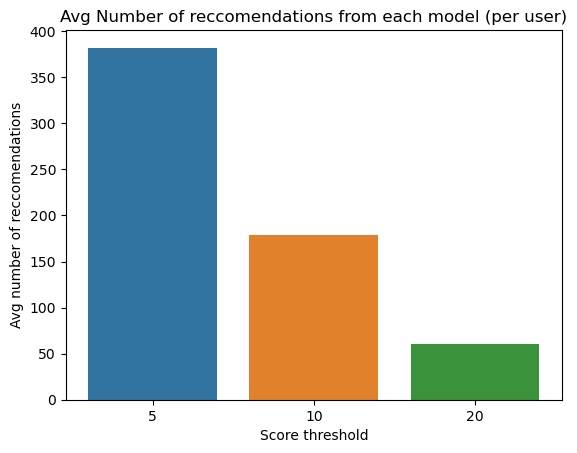

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
model_number = ["5", "10", "20"]
# create a dataframe with the values and names
df_results = pd.DataFrame({'Avg number of reccomendations': number_of_reccomendations, 'Score threshold': model_number})

# use seaborn to plot the bar chart
sns.barplot(x='Score threshold', y='Avg number of reccomendations', data=df_results)
plt.title('Avg Number of reccomendations from each model (per user)')
plt.plot()

In [19]:
number_of_reccomendations

[382.042904290429, 178.63210702341138, 60.324909747292416]

[]

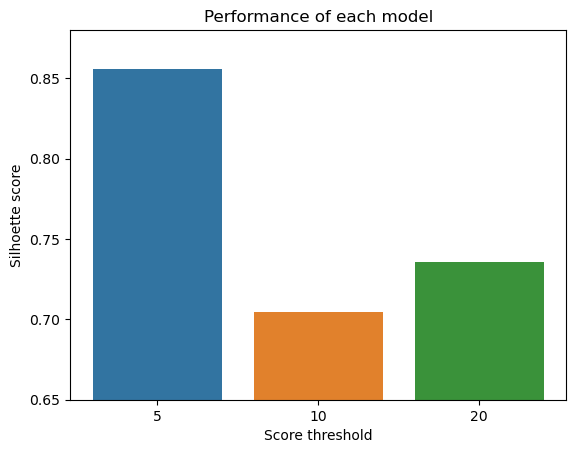

In [48]:
silhouette_score_list = [silhouette_score_1, silhouette_score_2, silhouette_score_3]

# create a dataframe with the values and names
df_accuracy = pd.DataFrame({'Silhoette score': silhouette_score_list, 'Score threshold': model_number})

# use seaborn to plot the bar chart
sns.barplot(x='Score threshold', y='Silhoette score', data=df_accuracy)
plt.title('Performance of each model')
plt.ylim(0.65, 0.88)
plt.plot()

In [47]:
silhouette_score_list = [0.855591555111784, 0.7048235135407214, 0.735516692120864]
silhouette_score_1 = silhouette_score_list[0]
silhouette_score_2 = silhouette_score_list[1]
silhouette_score_3 = silhouette_score_list[2]

In [49]:
top_10_courses_model_1

,COURSE_ID,number_of_reccomendations
0,TA0106EN,783
1,GPXX0TY1EN,780
2,GPXX0IBEN,756
3,excourse06,755
4,excourse04,755
5,excourse21,741
6,excourse22,741
7,ML0122EN,730
8,excourse12,729
9,excourse31,713


In [55]:
merged_df = pd.merge(top_10_courses_model_1, course_genres_df, left_on='COURSE_ID', right_on='COURSE_ID')

In [59]:
merged_df.iloc[:, :3]

,COURSE_ID,number_of_reccomendations,TITLE
0,TA0106EN,783,text analytics at scale
1,GPXX0TY1EN,780,performing database operations in the cloudant...
2,GPXX0IBEN,756,data science in insurance basic statistical a...
3,excourse06,755,sql for data science capstone project
4,excourse04,755,sql for data science
5,excourse21,741,applied machine learning in python
6,excourse22,741,introduction to data science in python
7,ML0122EN,730,accelerating deep learning with gpu
8,excourse12,729,python scripting files inheritance and data...
9,excourse31,713,cloud computing applications part 2 big data...
